# **Dataset & Description**



[![image.png](attachment:image.png)](http://)


The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.








[Dataset link ](https://www.kaggle.com/msambare/fer2013)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/temp/facialexpression.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train/sad/Training_65242339.jpg  
  inflating: train/train/sad/Training_65267116.jpg  
  inflating: train/train/sad/Training_65275626.jpg  
  inflating: train/train/sad/Training_6529266.jpg  
  inflating: train/train/sad/Training_65329617.jpg  
  inflating: train/train/sad/Training_65338712.jpg  
  inflating: train/train/sad/Training_65338797.jpg  
  inflating: train/train/sad/Training_65387162.jpg  
  inflating: train/train/sad/Training_65404494.jpg  
  inflating: train/train/sad/Training_65426218.jpg  
  inflating: train/train/sad/Training_65430136.jpg  
  inflating: train/train/sad/Training_65437377.jpg  
  inflating: train/train/sad/Training_6545735.jpg  
  inflating: train/train/sad/Training_65463385.jpg  
  inflating: train/train/sad/Training_65473985.jpg  
  inflating: train/train/sad/Training_65502829.jpg  
  inflating: train/train/sad/Training_65505359.jpg  
  inflating: train/train/sad/Training_65508578.jpg

In [ ]:
##### DATA AUGMENTATION ######

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/train/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/train/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/test/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [ ]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

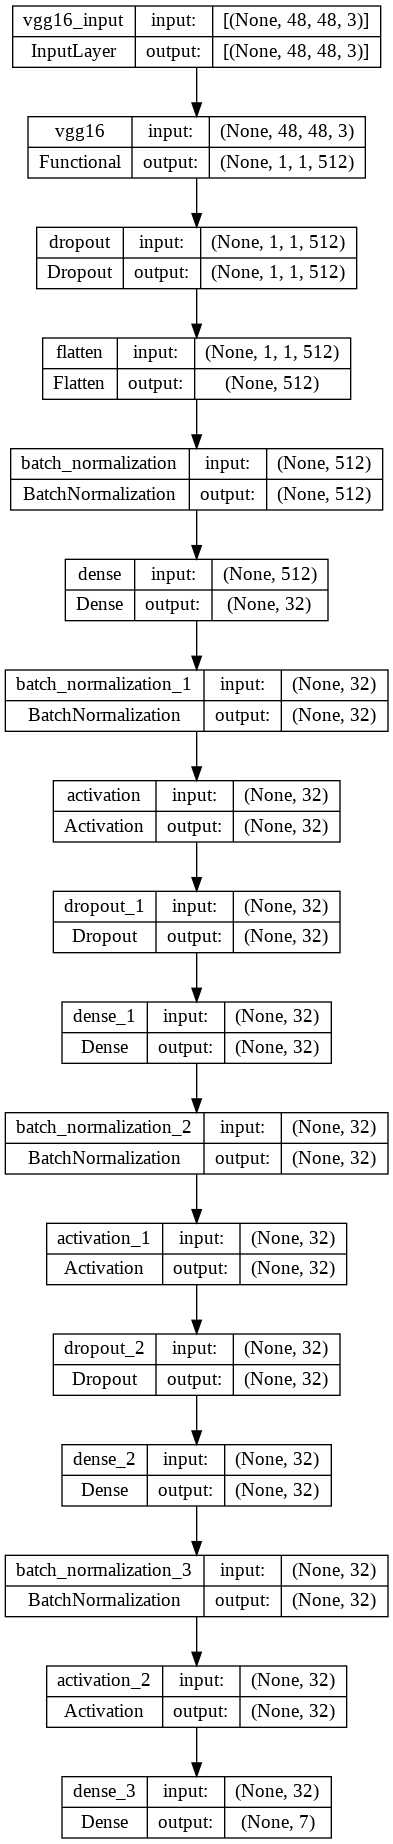

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/5
359/359 [==============================] - 44s 92ms/step - loss: 1.9523 - accuracy: 0.8545 - precision: 0.1992 - recall: 0.0061 - auc: 0.5944 - f1_score: 0.0115 - val_loss: 1.8368 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6349 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/5
359/359 [==============================] - 32s 88ms/step - loss: 1.8371 - accuracy: 0.8569 - precision: 0.4163 - recall: 0.0042 - auc: 0.6341 - f1_score: 0.0082 - val_loss: 1.8097 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6533 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/5
359/359 [==============================] - 31s 87ms/step - loss: 1.8157 - accuracy: 0.8571 - precision: 0.4302 - recall: 0.0016 - auc: 0.6478 - f1_score: 0.0032 - val_loss: 1.8185 - val_accuracy: 0.8572 - val_precision: 1.0000 - val_recall: 3.4837e-04 - val_auc: 0.6501 - val_f1_score: 6.8376e-04 - lr: 0.0010
Epoch 4/5
359/359 [=============

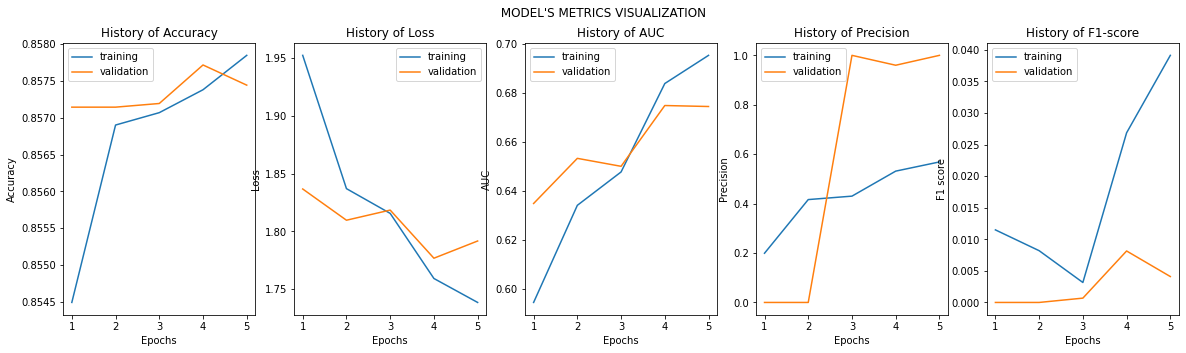

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
history=model.fit(train_dataset,validation_data=test_dataset,epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/5
359/359 [==============================] - 32s 90ms/step - loss: 1.7182 - accuracy: 0.8587 - precision: 0.6178 - recall: 0.0284 - auc: 0.7043 - f1_score: 0.0542 - val_loss: 1.6762 - val_accuracy: 0.8599 - val_precision: 0.7831 - val_recall: 0.0272 - val_auc: 0.7268 - val_f1_score: 0.0514 - lr: 0.0010
Epoch 2/5
359/359 [==============================] - 32s 88ms/step - loss: 1.7025 - accuracy: 0.8591 - precision: 0.6403 - recall: 0.0314 - auc: 0.7116 - f1_score: 0.0596 - val_loss: 1.6916 - val_accuracy: 0.8591 - val_precision: 0.8657 - val_recall: 0.0162 - val_auc: 0.7197 - val_f1_score: 0.0311 - lr: 0.0010
Epoch 3/5
359/359 [==============================] - 32s 88ms/step - loss: 1.6999 - accuracy: 0.8589 - precision: 0.6202 - recall: 0.0312 - auc: 0.7128 - f1_score: 0.0591 - val_loss: 1.7042 - val_accuracy: 0.8579 - val_precision: 0.7826 - val_recall: 0.0075 - val_auc: 0.7172 - val_f1_score: 0.0146 - lr: 0.0010
Epoch 4/5
359/359 [==============================] - 33s 91ms/st